In [5]:
import re, os
import pandas as pd
import numpy as np
from pathlib import Path

# Preparation

## Variables

In [57]:
results_dir = Path("/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/")
ORA_dir = Path("/Users/janzules/Roselab/Metabolite/results/ORA_python")

files = [f for f in results_dir.iterdir() if f.is_file()]

B0 = files[2]
D5 = files[1]
F3 = files[3]
F6 = files[0]

In [107]:
files

[PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_F6_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_D5_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_B0_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_F3_IF_vs_NIF.csv')]

In [82]:
# Selecting final file
met_df = pd.read_csv(F3)

In [83]:
FEATURE_COL = "Index"        # unique metabolite identifier (or name)
KEGG_COL    = "kegg_maps"    # strings like "ko04211,ko04218"
PVAL_COL   = "P.Value"       # <- use your limma p-value column
LOGFC_COL   = "logFC"        # optional
ALPHA       = 0.05           # significance threshold

# Parsing

In [84]:
# Parse Kegg id's
pattern = re.compile(r'(?:ko|map|hsa)?(\d{5})$')

# Split on comma/semicolon/pipe/space, strip, keep unique 5-digit codes, sorted for stability
parsed_series = (
    met_df["kegg_map"]
    .astype(str)
    .map(lambda x: re.split(r',', x) if x.strip() != "-" else [])
    .map(lambda toks: sorted({m.group(1) for t in toks if (m := pattern.match(t.strip()))}))
)

df = met_df.copy()
df["kegg_ids"] = parsed_series

In [85]:
# tmp

In [86]:
df["p_nom"] = df[PVAL_COL].astype(float)
universe = df[df["kegg_ids"].map(len) > 0].copy()
sig_any  = universe.loc[universe["p_nom"] <= ALPHA].copy()

# optional directional splits
if "logFC" in df.columns:
    sig_up = sig_any.loc[sig_any["logFC"] > 0].copy()
    sig_dn = sig_any.loc[sig_any["logFC"] < 0].copy()
else:
    sig_up = sig_any.iloc[0:0]
    sig_dn = sig_any.iloc[0:0]

In [87]:
print(sig_up.shape)
print(sig_dn.shape)

(27, 37)
(18, 37)


In [88]:
sig_dn.shape

(18, 37)

In [89]:
# Build gene sets (GMT) from your data (universe-aware)
uni_long = universe[[FEATURE_COL, "kegg_ids"]].explode("kegg_ids").rename(columns={"kegg_ids":"pathway_id"})
members_by_pw = uni_long.groupby("pathway_id")[FEATURE_COL].apply(lambda s: sorted(set(s))).to_dict()

In [90]:
# # Fetch KEGG pathway names (existing API via bioservices)
# try:
#     from bioservices import KEGG
#     kegg = KEGG()
#     path_names = {}
#     for pid in members_by_pw.keys():
#         # Use general maps to avoid organism-specific suffixes
#         txt = kegg.get(f"path:map{pid}")  # e.g., map04211
#         # crude parse for NAME line
#         name = None
#         for line in txt.splitlines():
#             if line.strip().startswith("NAME"):
#                 name = line.split("NAME",1)[1].strip()
#                 break
#         path_names[pid] = name or pid
# except Exception as e:
#     # Fallback: use the ID itself
#     path_names = {pid: pid for pid in members_by_pw.keys()}

In [91]:
path_names

{'00010': 'Glycolysis / Gluconeogenesis',
 '00020': 'Citrate cycle (TCA cycle)',
 '00030': 'Pentose phosphate pathway',
 '00040': 'Pentose and glucuronate interconversions',
 '00051': 'Fructose and mannose metabolism',
 '00052': 'Galactose metabolism',
 '00053': 'Ascorbate and aldarate metabolism',
 '00061': 'Fatty acid biosynthesis',
 '00062': 'Fatty acid elongation',
 '00071': 'Fatty acid degradation',
 '00100': 'Steroid biosynthesis',
 '00120': 'Primary bile acid biosynthesis',
 '00130': 'Ubiquinone and other terpenoid-quinone biosynthesis',
 '00140': 'Steroid hormone biosynthesis',
 '00190': 'Oxidative phosphorylation',
 '00220': 'Arginine biosynthesis',
 '00230': 'Purine metabolism',
 '00232': 'Caffeine metabolism',
 '00240': 'Pyrimidine metabolism',
 '00250': 'Alanine, aspartate and glutamate metabolism',
 '00260': 'Glycine, serine and threonine metabolism',
 '00270': 'Cysteine and methionine metabolism',
 '00280': 'Valine, leucine and isoleucine degradation',
 '00290': 'Valine, 

In [92]:
# Write a temporary GMT for GSEApy (set_name, description, members...)
gmt_path = ORA_dir / "kegg_from_dataset.gmt"
with open(gmt_path, "w") as fh:
    for pid, members in members_by_pw.items():
        if not members: 
            continue
        set_name = f"KEGG_{pid}_{re.sub(r'\\W+','_', path_names.get(pid, pid))}"
        desc = f"path:{pid}"
        fh.write("\t".join([set_name, desc, *members]) + "\n")


In [93]:
gene_list_any = sorted(sig_any[FEATURE_COL].unique().tolist())
background    = sorted(universe[FEATURE_COL].unique().tolist())

In [94]:
# import re, os
# from pathlib import Path

# # members_by_pw: {'04211': ['MEDN1278','MW0015050', ...], ...}
# # gmt_path = Path("kegg_from_dataset.gmt")

# def safe_name(s):
#     # no spaces or punctuation in set names
#     return re.sub(r"\W+", "_", s)

# with gmt_path.open("w") as fh:
#     for pid, members in members_by_pw.items():
#         if not members:        # skip empty sets
#             continue
#         set_name = safe_name(f"KEGG_{pid}")
#         desc = f"path:{pid}"
#         fh.write("\t".join([set_name, desc, *members]) + "\n")


In [95]:
# must exist and be non-empty
assert gmt_path.exists() and gmt_path.stat().st_size > 0

# print first 2 lines
with gmt_path.open() as fh:
    for i, line in enumerate(fh):
        print(repr(line.rstrip("\n")))
        if i == 1: break


'KEGG_00010_Glycolysis / Gluconeogenesis\tpath:00010\tMEDN0204\tMW0112272\tMW0156503'
'KEGG_00020_Citrate cycle (TCA cycle)\tpath:00020\tMEDN0204\tMW0109022'


In [96]:
import gseapy as gp
from pathlib import Path

gene_list_any = sorted(sig_any[FEATURE_COL].unique())
background    = sorted(universe[FEATURE_COL].unique())

outdir = ORA_dir / "gseapy_kegg_ora_any"
os.makedirs(outdir, exist_ok=True)

enr_any = gp.enrichr(
    gene_list=gene_list_any,
    gene_sets=str(gmt_path),   # <— ensure string, not Path
    format="gmt",              # <— force GMT parsing
    background=background,
    outdir=str(outdir),
    cutoff=1.0,
    no_plot=True,
)
res_any = enr_any.results.copy()


In [97]:
res_any

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,kegg_from_dataset.gmt,KEGG_00040_Pentose and glucuronate interconver...,1/6,0.240853,0.818764,5.855975,8.336389,MW0017084
1,kegg_from_dataset.gmt,KEGG_00051_Fructose and mannose metabolism,1/5,0.205081,0.818764,7.164794,11.351530,MEDN1011
2,kegg_from_dataset.gmt,KEGG_00053_Ascorbate and aldarate metabolism,1/6,0.240853,0.818764,5.855975,8.336389,MW0017084
3,kegg_from_dataset.gmt,KEGG_00100_Steroid biosynthesis,1/6,0.240853,0.818764,5.855975,8.336389,MW0142181
4,kegg_from_dataset.gmt,KEGG_00120_Primary bile acid biosynthesis,1/8,0.307737,0.818764,4.285393,5.050382,MW0053750
5,kegg_from_dataset.gmt,KEGG_00130_Ubiquinone and other terpenoid-quin...,1/10,0.368848,0.818764,3.376109,3.367236,MW0142982
6,kegg_from_dataset.gmt,KEGG_00140_Steroid hormone biosynthesis,2/23,0.275333,0.818764,2.511361,3.239091,MW0013552;MW0012734
7,kegg_from_dataset.gmt,KEGG_00232_Caffeine metabolism,1/11,0.397392,0.818764,3.051364,2.815896,MW0123194
8,kegg_from_dataset.gmt,KEGG_00380_Tryptophan metabolism,1/9,0.338982,0.818764,3.777264,4.086272,MW0104674
9,kegg_from_dataset.gmt,"KEGG_00400_Phenylalanine, tyrosine and tryptop...",1/9,0.338982,0.818764,3.777264,4.086272,MW0112793


# Filtering classes

In [98]:
# You already have: res_any with Term like "KEGG_00030_Pentose phosphate pathway"
import re
from bioservices import KEGG

# Extract 5-digit ID
res_any["pathway_id"] = res_any["Term"].str.extract(r"KEGG_(\d{5})")

# Fetch class + name once per pathway
kegg = KEGG()
klass, pname = {}, {}
for pid in res_any["pathway_id"].dropna().unique():
    txt = kegg.get(f"path:map{pid}")
    parsed = kegg.parse(txt) if txt else {}
    # NAME
    nm = parsed.get("NAME")
    if isinstance(nm, list): nm = nm[0]
        pname[pid] = (nm or "").rstrip(";").strip() or pid
        # CLASS (e.g., "Metabolism; Carbohydrate metabolism")
        cl = parsed.get("CLASS")
    if isinstance(cl, list): cl = cl[0]
        klass[pid] = (cl or "").strip()

# Add columns
res_any["kegg_class"] = res_any["pathway_id"].map(klass).fillna("")
res_any["pathway_name"] = res_any["pathway_id"].map(pname).fillna(res_any["pathway_id"])


In [99]:
# Option A: keep only Metabolism
res_met = res_any[res_any["kegg_class"].str.startswith("Metabolism")].copy()

# Option B: exclude Human Diseases
# res_met = res_any[~res_any["kegg_class"].str.startswith("Human Diseases")].copy()


# Visualizing

In [108]:
-np.log10(0.05)

1.3010299956639813

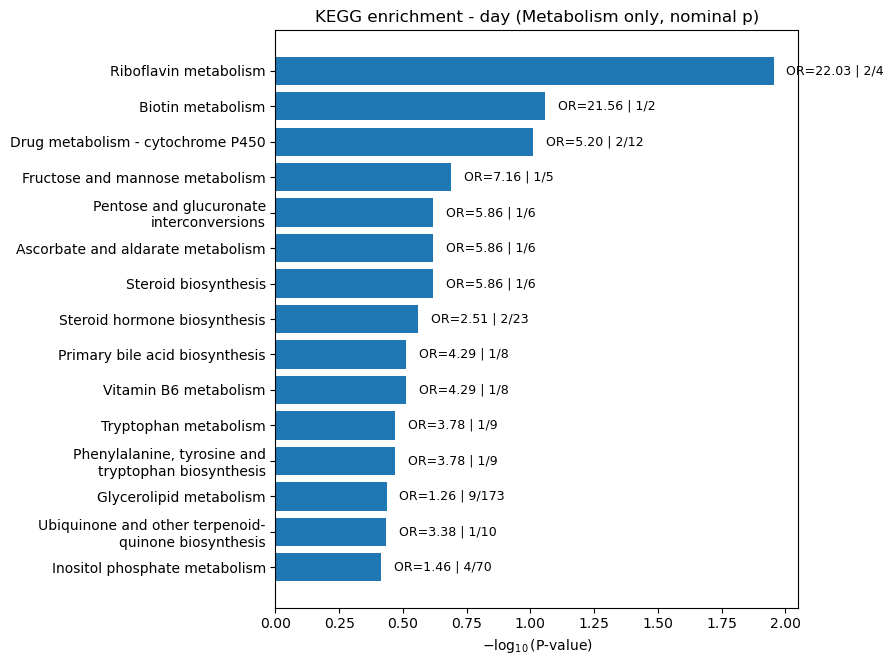

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

res_met = res_met.sort_values(["P-value", "Term"]).copy()
res_met["neglog10p"] = -np.log10(res_met["P-value"].astype(float))
res_met["label"] = res_met["pathway_name"].map(lambda s: "\n".join(wrap(str(s), width=35)))

# TOP_N = 15
# top = res_met.nsmallest(TOP_N, "P-value")

# plt.figure(figsize=(9, max(4, 0.45*len(top))))
# y = np.arange(len(top))[::-1]
# plt.barh(y, top["neglog10p"].values)
# plt.yticks(y, top["label"].values)
# plt.xlabel(r"$-\log_{10}(\mathrm{P\text{-}value})$")
# plt.title("KEGG enrichment - day (Metabolism only, nominal p)")
# for i,(xv, orr, ov) in enumerate(zip(top["neglog10p"], top["Odds Ratio"], top["Overlap"])):
#     plt.text(xv+0.05, y[i], f"OR={orr:.2f} | {ov}", va="center", fontsize=9)
# plt.tight_layout()
# plt.show()


In [101]:
sig_any.shape

(45, 37)

In [102]:
universe.shape

(1005, 37)

# Up and Down

In [111]:
import gseapy as gp
import re, numpy as np, pandas as pd, os

gene_list_up = sorted(sig_up[FEATURE_COL].unique())
gene_list_dn = sorted(sig_dn[FEATURE_COL].unique())
background   = sorted(universe[FEATURE_COL].unique())

out_up = ORA_dir / "gseapy_kegg_ora_up";  os.makedirs(out_up, exist_ok=True)
out_dn = ORA_dir / "gseapy_kegg_ora_dn";  os.makedirs(out_dn, exist_ok=True)

enr_up = gp.enrichr(gene_list=gene_list_up, gene_sets=str(gmt_path), format="gmt",
                    background=background, outdir=str(out_up), cutoff=1.0, no_plot=True)
enr_dn = gp.enrichr(gene_list=gene_list_dn, gene_sets=str(gmt_path), format="gmt",
                    background=background, outdir=str(out_dn), cutoff=1.0, no_plot=True)

res_up = enr_up.results.copy()
res_dn = enr_dn.results.copy()

# parse pathway_id + (optional) name if you embedded it in Term
def split_term(term):
    m = re.match(r"KEGG_(\d{5})_(.*)$", str(term))
    return (m.group(1), m.group(2).strip()) if m else (None, str(term))

for _df in (res_up, res_dn):
    _tmp = _df["Term"].map(split_term)
    _df["pathway_id"]   = [t[0] for t in _tmp]
    _df["pathway_name"] = [t[1] for t in _tmp]
    _df["neglog10p"]    = -np.log10(_df["P-value"].astype(float))


In [104]:
# If you already computed res_any["kegg_class"], reuse that mapping:
# klass: dict {pid -> "Metabolism; ..."}
res_up["kegg_class"] = res_up["pathway_id"].map(klass).fillna("")
res_dn["kegg_class"] = res_dn["pathway_id"].map(klass).fillna("")
res_up = res_up[res_up["kegg_class"].str.startswith("Metabolism")].copy()
res_dn = res_dn[res_dn["kegg_class"].str.startswith("Metabolism")].copy()


In [105]:
def add_overlap_counts(df):
    kk = df["Overlap"].str.split("/", expand=True).astype(int)
    df["k_in_set"] = kk[0]      # sig hits in this pathway
    df["K_size"]   = kk[1]      # pathway size in background
    df["k_over_n"] = df["k_in_set"] / len(gene_list_up if df is res_up else gene_list_dn)  # optional
    return df

res_up = add_overlap_counts(res_up)
res_dn = add_overlap_counts(res_dn)

res_up = res_up[res_up["k_in_set"] >= 2].copy()
res_dn = res_dn[res_dn["k_in_set"] >= 2].copy()


In [ ]:
import matplotlib.pyplot as plt
from textwrap import wrap

def plot_top(df, title, out_png, topn=15):
    if df.empty:
        print(f"No enriched pathways to plot for: {title}")
        return
    df = df.sort_values(["P-value","Term"]).head(topn).copy()
    df["label"] = df["pathway_name"].map(lambda s: "\n".join(wrap(str(s), width=35)))

    plt.figure(figsize=(9, max(4, 0.45*len(df))))
    y = np.arange(len(df))[::-1]
    plt.barh(y, df["neglog10p"].values)
    plt.yticks(y, df["label"].values)
    plt.xlabel(r"$-\log_{10}(\mathrm{P\text{-}value})$")
    plt.title(title)
    for i,(xv, orr, ov) in enumerate(zip(df["neglog10p"], df["Odds Ratio"], df["Overlap"])):
        plt.text(xv+0.05, y[i], f"OR={orr:.2f} | {ov}", va="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

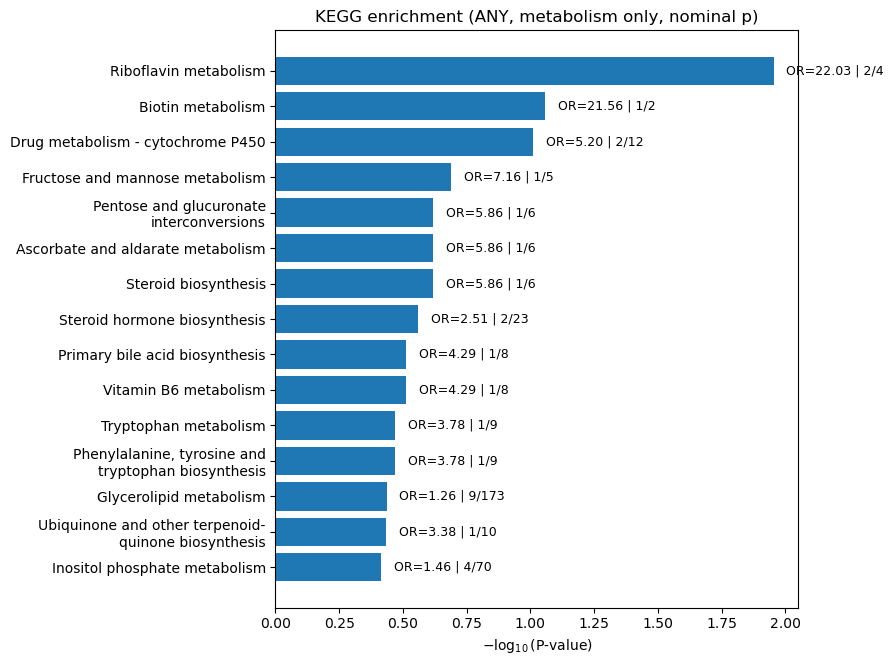

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_any_nominalP.png


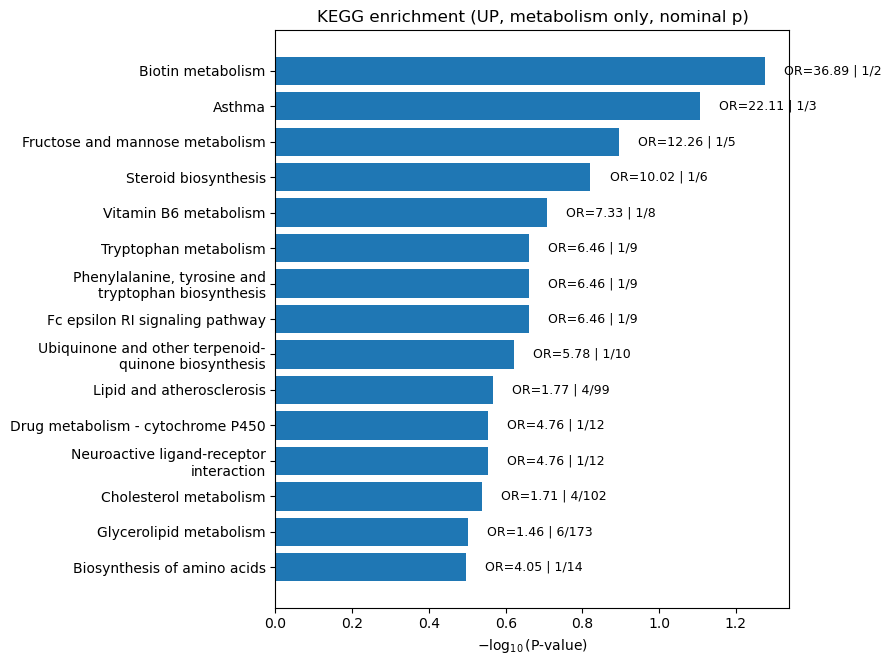

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_up_nominalP.png


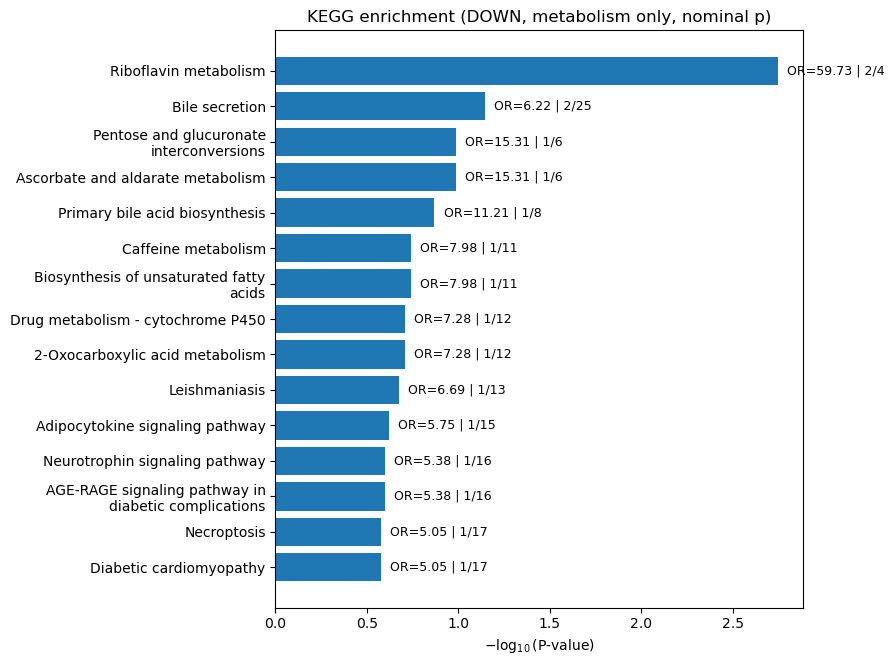

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_dn_nominalP.png


In [112]:
plot_top(res_met, "KEGG enrichment - {day}",
        ORA_dir / "plots/met_kegg_enrichment_any_nominalP.png")

plot_top(res_up, "KEGG enrichment (UP, metabolism only, nominal p)",
         ORA_dir / "plots/met_kegg_enrichment_up_nominalP.png")

plot_top(res_dn, "KEGG enrichment (DOWN, metabolism only, nominal p)",
         ORA_dir / "plots/met_kegg_enrichment_dn_nominalP.png")